In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import cv2
import pandas as pd

plt.style.use('ggplot')

In [2]:
DATASET_DIR="../dataset/10/"

In [3]:
def plot_cumulative_error(algorithm_errors : list[np.ndarray],
                          titles : list[str],
                          ) -> None:
    total_samples = len(algorithm_errors[0])
    errors = []
    for err in algorithm_errors:
        errors.extend(err)
    x_values = sorted(set(errors))
    
    fig, ax = plt.subplots()
   
    # Plot cumulative error distribution
    for errors, title in zip(algorithm_errors, titles):
        alg_err_dist = [sum(1 for error in errors if error <= x) / total_samples for x in x_values]
        ax.plot(x_values, alg_err_dist, label=title)
        
    ax.set_ylabel("Percentage of Images")
    ax.set_xlabel("Detection Error")
    ax.set_title("Cumulative Error Distribution of Each Algorithm")

    # Set tick labels with units using formatters
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.0f}px"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y*100:.0f}%"))

    ax.legend()
    plt.show()


In [4]:
def dummy_method(image: np.ndarray):
    return image.shape[0]//2, image.shape[1]//2

### NOTA

Hay mas anotaciones que imagenes, fijarse bien el tema de las anotaciones 
como se indexan y eso, a que frame corresponde cada point anotation

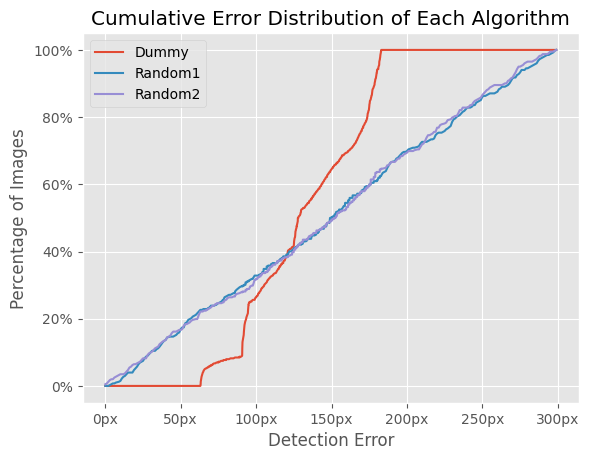

In [5]:
import glob

subfolder="1"
img_paths = glob.glob(f"{DATASET_DIR}/{subfolder}/*.jpg")

annot_path = f"{DATASET_DIR}/{subfolder}/{subfolder}.txt"
ground_truth = pd.read_csv(annot_path, sep=" ", header=None)
ground_truth.columns = ["x", "y"]

results = []
for index, path in enumerate(img_paths):
    img = cv2.imread(path)
    error = np.sqrt(np.sum((ground_truth.iloc[index].values - dummy_method(img))**2))
    results.append(error)
    
rand_errs = np.random.randint(0, 300, size=len(results))
rand_errs2 = np.random.randint(0, 300, size=len(results))
plot_cumulative_error([results, rand_errs, rand_errs2], 
                      ["Dummy", "Random1", "Random2"])

### Algoritmo

(588, 119) (17, 37) 89.13336944580078
10 36
0.2777777777777778
(584, 123) (24, 45) 90.72685241699219
5 81
0.06172839506172839
(557, 68) (2, 19) 76.0570068359375
0 0
nan
(452, 73) (22, 39) 130.94618225097656
64 64
1.0
(595, 59) (1, 45) 64.15731811523438
0 0
nan
(583, 48) (4, 37) 67.57661437988281
0 1
0.0
(557, 20) (4, 33) 63.757110595703125
1 1
1.0
(572, 28) (1, 28) 59.43227767944336
0 0
nan
(570, 26) (1, 25) 58.32514572143555
0 0
nan
(566, 12) (2, 30) 65.37582397460938
0 0
nan


C:\Users\mathi\AppData\Local\Temp\ipykernel_18680\1717319426.py:48: RuntimeWarning: invalid value encountered in scalar divide
  black_pixels_percentage = black_pixels / total_pixels


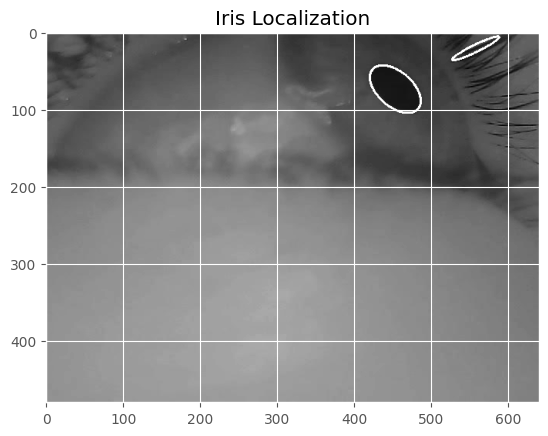

In [230]:
# Iris Localization

def iris_localization(image):

    # Apply Gaussian filtering for smoothing
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(smoothed, 50, 100) # Adjust the threshold as needed
    #edges = skimage.feature.canny(image, sigma=3, low_threshold=10, high_threshold=50)
    
    #plt.imshow(edges, cmap="gray")

    # Apply Hough transform for circle detection
    #circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20, param1=50, param2=10, minRadius=10, maxRadius=150)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
    # plt.imshow(image)
    ellipses = []
    for contour in contours:
        if len(contour) >= 60:
            ellipse = cv2.fitEllipse(contour)

            # Unpack the ellipse parameters
            (center_x, center_y), (major_axis, minor_axis), angle = ellipse
            
            # Convert the parameters to integer values
            center = (int(center_x), int(center_y))
            axes = (int(major_axis / 2), int(minor_axis / 2))

            print(center, axes, angle)
            
            # Calculate the size of the square based on a scale factor
            scale_factor = 0.4
            square_size = int(min(axes) * scale_factor)
            
            # Define the coordinates of the square
            x = center[0] - square_size // 2
            y = center[1] - square_size // 2
            
            # Extract the square region of interest (ROI) from the image
            roi = image[y:y+square_size, x:x+square_size]
            
            # Calculate the percentage of black pixels within the ROI
            black_pixels = np.sum(roi < 45)
            total_pixels = roi.size
            black_pixels_percentage = black_pixels / total_pixels

            print(black_pixels, total_pixels)
            print(black_pixels_percentage)

            if black_pixels_percentage > 0.9:
                ellipses.append(ellipse)

    

    return ellipses

def draw_ellipses(image: np.ndarray, ellipses):
    if ellipses is not None:
        for ellipse in ellipses:
            cv2.ellipse(image, ellipse, (255, 255, 255), 2)
    # if circles is not None:
    #     circles = np.round(circles[0, :]).astype("int")
    #     for (x, y, r) in circles:
    #         cv2.circle(image, (x, y), r, (0,255,0), 2)

    plt.imshow(image, cmap="gray") 
    plt.title("Iris Localization")
    plt.show()

# Test
image = cv2.imread(f"{DATASET_DIR}/2/2_290.jpg", 0) # Read as grayscale

ellipses = iris_localization(image)
draw_ellipses(image, ellipses)

idea mejorar deteccion pupila.
tomar ventana de n pixeles a cada lado del centro de la elipse encontrada y verificar que el color dentro de la elipse sea negro (np.count_nonzero(window==0))
